In [1]:
# ------------------------------------------define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.Tensorflow_helper import choose_gpu_by_id
# ------------------------------------------define GPU id/s to use
GPU_IDS = '0,1'
GPUS = choose_gpu_by_id(GPU_IDS)
print(GPUS)
# ------------------------------------------jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# ------------------------------------------ import helpers
# this should import glob, os, and many other standard libs
from src.utils.Notebook_imports import *
from src.utils.Utils_io import Console_and_file_logger, init_config
from tensorflow.python.client import device_lib
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
# local imports
"""
from src.visualization.Visualize import show_2D_or_3D, show_phases, show_phases_transpose
from src.utils.KerasCallbacks import get_callbacks
from src.data.Dataset import get_trainings_files"""

# import external libs
import cv2
import pandas as pd

EXPERIMENT = 'cv_baseline/8_64_64__8_3_3_tenc64_conv1_MSE_NOnorm_augshiftscalerotdown_taug3_3_batch8_f0'
#EXPERIMENT = 'baseline_label_transpose_smooth05/36_5_BiLSTM32_NoBn_conv5_size1_CCE_NOphaseaug_NOaug_b8'
# EXPERIMENT = 'mased_scores/36_5_BiLSTM32_NoBn_conv5_size1_CCE_NOphaseaug_shift_rotate_reflectbordersgridaug'
timestemp = str(datetime.datetime.now().strftime("%Y-%m-%d_%H_%M")) # ad a timestep to each project to make repeated experiments unique

EXPERIMENTS_ROOT = 'exp/'
EXP_PATH = os.path.join(EXPERIMENTS_ROOT, EXPERIMENT, timestemp)
MODEL_PATH = os.path.join(EXP_PATH, 'model', )
TENSORBOARD_PATH = os.path.join(EXP_PATH, 'tensorboard_logs')
CONFIG_PATH = os.path.join(EXP_PATH,'config')
HISTORY_PATH = os.path.join(EXP_PATH, 'history')
ensure_dir(MODEL_PATH)
ensure_dir(TENSORBOARD_PATH)
ensure_dir(CONFIG_PATH)
ensure_dir(HISTORY_PATH)

# define the data paths and fold 
# first to the 4D Nrrd files, 
# second to a dataframe with a mapping of the Fold-number - filename
DATA_PATH_SAX = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAX/'
DF_FOLDS = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/df_kfold.csv'
DF_META = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase'
FOLD = 0

# General params
SEED = 42 # define a seed for the generator shuffle
BATCHSIZE = 8 # 32, 64, 24, 16, 1 for 3D use: 4
GENERATOR_WORKER = BATCHSIZE # if not set, use batchsize
EPOCHS = 200

DIM = [8, 64, 64] # network input shape for spacing of 3, (z,y,x)
T_SHAPE = 36
SPACING = [8, 3, 3] # if resample, resample to this spacing, (z,y,x)

# Model params
DEPTH = 3 # depth of the encoder
FILTERS = 64 # initial number of filters, will be doubled after each downsampling block
M_POOL = [1, 2, 2]# size of max-pooling used for downsampling and upsampling
F_SIZE = [3, 3, 3] # conv filter size
BN_FIRST = False # decide if batch normalisation between conv and activation or afterwards
BATCH_NORMALISATION = True # apply BN or not
PAD = 'same' # padding strategy of the conv layers
KERNEL_INIT = 'he_normal' # conv weight initialisation
OPTIMIZER = 'adam' # Adam, Adagrad, RMSprop, Adadelta,  # https://keras.io/optimizers/
ACTIVATION = 'relu' # tf.keras.layers.LeakyReLU(), relu or any other non linear activation function
LEARNING_RATE = 1e-4 # start with a huge lr to converge fast
REDUCE_LR_ON_PLAEAU_PATIENCE = 5
DECAY_FACTOR = 0.7 # Define a learning rate decay for the ReduceLROnPlateau callback
MIN_LR = 1e-12 # minimal lr, smaller lr does not improve the model
DROPOUT_min = 0.3 # lower dropout at the shallow layers
DROPOUT_max = 0.5 # higher dropout at the deep layers

# Callback params
MONITOR_FUNCTION = 'loss'
MONITOR_MODE = 'min'
SAVE_MODEL_FUNCTION = 'loss'
SAVE_MODEL_MODE = 'min'
MODEL_PATIENCE = 20
SAVE_LEARNING_PROGRESS_AS_TF = True

# Generator and Augmentation params
BORDER_MODE = cv2.BORDER_REFLECT_101 # border mode for the data generation
IMG_INTERPOLATION = cv2.INTER_LINEAR # image interpolation in the genarator
MSK_INTERPOLATION = cv2.INTER_NEAREST # mask interpolation in the generator
AUGMENT = True # a compose of 2D augmentation (grid distortion, 90degree rotation, brightness and shift)
AUGMENT_PROB = 0.8
AUGMENT_PHASES = True
AUGMENT_PHASES_RANGE = (-3,3)
REPEAT_ONEHOT = True
SHUFFLE = True
RESAMPLE = True
SCALER = 'MinMax' # MinMax, Standard or Robust
# We define 5 target phases and a background phase for the pad/empty volumes 
PHASES = len(['ED#', 'MS#', 'ES#', 'PF#', 'MD#']) # skipped 'pad backround manually added', due to repeating
TARGET_SMOOTHING = True
SMOOTHING_KERNEL_SIZE = 12
SMOOTHING_LOWER_BORDER = 1
SMOOTHING_UPPER_BORDER = 5
SMOOTHING_WEIGHT_CORRECT = 10
config = init_config(config=locals(), save=True)

"""Console_and_file_logger(EXPERIMENT, logging.INFO)

print(config)
logging.info('Is built with tensorflow: {}'.format(tf.test.is_built_with_cuda()))
logging.info('Visible devices:\n{}'.format(tf.config.list_physical_devices()))
logging.info('Local devices: \n {}'.format(device_lib.list_local_devices()))"""

search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/dynamic-cmr-models
['/gpu:0', '/gpu:1']


"Console_and_file_logger(EXPERIMENT, logging.INFO)\n\nprint(config)\nlogging.info('Is built with tensorflow: {}'.format(tf.test.is_built_with_cuda()))\nlogging.info('Visible devices:\n{}'.format(tf.config.list_physical_devices()))\nlogging.info('Local devices: \n {}'.format(device_lib.list_local_devices()))"

In [ ]:
from src.models.train_model import train_fold

folds = [i for i in range(4)]

for f in folds:
    info('starting fold: {}'.format(f))
    config_ = config.copy()
    config_['FOLD'] = f
    train_fold(config_)

2021-03-02 09:55:17,134 INFO -------------------- Start --------------------
2021-03-02 09:55:17,134 INFO Working directory: /mnt/ssd/git/dynamic-cmr-models.
2021-03-02 09:55:17,134 INFO Log file: ./logs/cv_baseline/8_64_64__8_3_3_tenc64_conv1_MSE_NOnorm_augshiftscalerotdown_taug3_3_batch8_f0.log
2021-03-02 09:55:17,135 INFO Log level for console: INFO
2021-03-02 09:55:17,136 INFO Is built with tensorflow: True
2021-03-02 09:55:17,186 INFO Visible devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2021-03-02 09:55:17,855 INFO Local devices: 
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locali

['/gpu:0', '/gpu:1']
{'GPU_IDS': '0,1', 'GPUS': ['/gpu:0', '/gpu:1'], 'SEED': 42, 'EXPERIMENT': 'cv_baseline/8_64_64__8_3_3_tenc64_conv1_MSE_NOnorm_augshiftscalerotdown_taug3_3_batch8_f0', 'EXPERIMENTS_ROOT': 'exp/', 'EXP_PATH': 'exp/cv_baseline/8_64_64__8_3_3_tenc64_conv1_MSE_NOnorm_augshiftscalerotdown_taug3_3_batch8_f0/2021-03-02_09_55', 'MODEL_PATH': 'exp/cv_baseline/8_64_64__8_3_3_tenc64_conv1_MSE_NOnorm_augshiftscalerotdown_taug3_3_batch8_f0/2021-03-02_09_55/model', 'TENSORBOARD_PATH': 'exp/cv_baseline/8_64_64__8_3_3_tenc64_conv1_MSE_NOnorm_augshiftscalerotdown_taug3_3_batch8_f0/2021-03-02_09_55/tensorboard_logs', 'CONFIG_PATH': 'exp/cv_baseline/8_64_64__8_3_3_tenc64_conv1_MSE_NOnorm_augshiftscalerotdown_taug3_3_batch8_f0/2021-03-02_09_55/config', 'HISTORY_PATH': 'exp/cv_baseline/8_64_64__8_3_3_tenc64_conv1_MSE_NOnorm_augshiftscalerotdown_taug3_3_batch8_f0/2021-03-02_09_55/history', 'DATA_PATH_SAX': '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAX/', 'DF_FOLDS': '/mnt/ssd/data/gc

2021-03-02 09:55:17,856 INFO no files found, try to load with clean.nrrd/mask.nrrd pattern
2021-03-02 09:55:17,876 INFO Found 278 images/masks in /mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAX/
2021-03-02 09:55:17,876 INFO Patients train: 209
2021-03-02 09:55:17,887 INFO Selected 209 of 278 files with 209 of 279 patients for training fold 0
2021-03-02 09:55:17,888 INFO SAX train CMR: 209, SAX train masks: 209
2021-03-02 09:55:17,888 INFO SAX val CMR: 69, SAX val masks: 69
2021-03-02 09:55:17,901 INFO Check if we find the patient ID and phase mapping for all: 278 files.
2021-03-02 09:55:18,172 INFO Done!
2021-03-02 09:55:18,173 INFO Create DataGenerator
2021-03-02 09:55:18,174 INFO Datagenerator created with: 
 shape: [8, 64, 64]
 spacing: [8, 3, 3]
 batchsize: 8
 Scaler: MinMax
 Images: 209 
 Augment: True 
 Thread workers: 8
2021-03-02 09:55:18,174 INFO Data will be augmented (shift,scale and rotate) with albumentation
2021-03-02 09:55:18,186 INFO Smoothing kernel: 
[ 1.   1.8  2.6  

Shape after the temporal encoder
(None, 36, 8, 8, 8, 512)
Shape after GAP
(None, 36, 512)
Shape after Bi-LSTM layer
(None, 36, 512)
Shape after final conv layer
(None, 36, 5)


2021-03-02 09:55:22,121 INFO feed 4 Tensorboard is ready


Epoch 1/200
26/26 [==============================] - ETA: 0s - loss: 1.2020 - mse_wrapper: 1.2020 - ca_wrapper: 0.3651 - meandiff: 14.6971

2021-03-02 09:56:53,913 INFO (4, 2, 36, 5)
2021-03-02 09:56:54,629 INFO (4, 2, 36, 5)



Epoch 00001: loss improved from inf to 1.20203, saving model to exp/cv_baseline/8_64_64__8_3_3_tenc64_conv1_MSE_NOnorm_augshiftscalerotdown_taug3_3_batch8_f0/2021-03-02_09_55/model/model.h5
26/26 [==============================] - 63s 2s/step - loss: 1.2020 - mse_wrapper: 1.2020 - ca_wrapper: 0.3651 - meandiff: 14.6971 - val_loss: 2.5026 - val_mse_wrapper: 2.5026 - val_ca_wrapper: 0.2721 - val_meandiff: 18.0469 - lr: 1.0000e-04
Epoch 2/200
 3/26 [==>...........................] - ETA: 30s - loss: 0.9657 - mse_wrapper: 0.9657 - ca_wrapper: 0.4942 - meandiff: 10.9167

In [15]:
# predict the files from globals()['inputs']
pred = model(inputs, training=False)

[autoreload of src.utils.Metrics failed: Traceback (most recent call last):
  File "/home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/sven/anaconda3/envs/dcmr/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/sven/anaconda3/envs/dcmr/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 779, in exec_module
  File "<frozen importlib._bootstrap_external>", line 916, in get_code
  File "<frozen importlib._bootstrap_external>", line 846, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_r

In [50]:
temp = np.array([23, 17, 24, 18])
print(temp.shape)
empty = np.ones((4,36,5))
print(empty.shape)
second = empty[:]
second[:,0,0] = temp
np.stack([empty, second], axis=1).shape

(4,)
(4, 36, 5)


(4, 2, 36, 5)

In [13]:
# get the true idx
gt_idx = tf.math.argmax(outputs, axis=1).numpy()
print(gt_idx)
gt_max = gt_idx.max(axis=1).astype(int)
print(gt_max)

[[23  4  9 13 21]
 [ 0  5 10 15 17]
 [24  4  8 13 20]
 [ 0  6 12 17 18]]
[23 17 24 18]


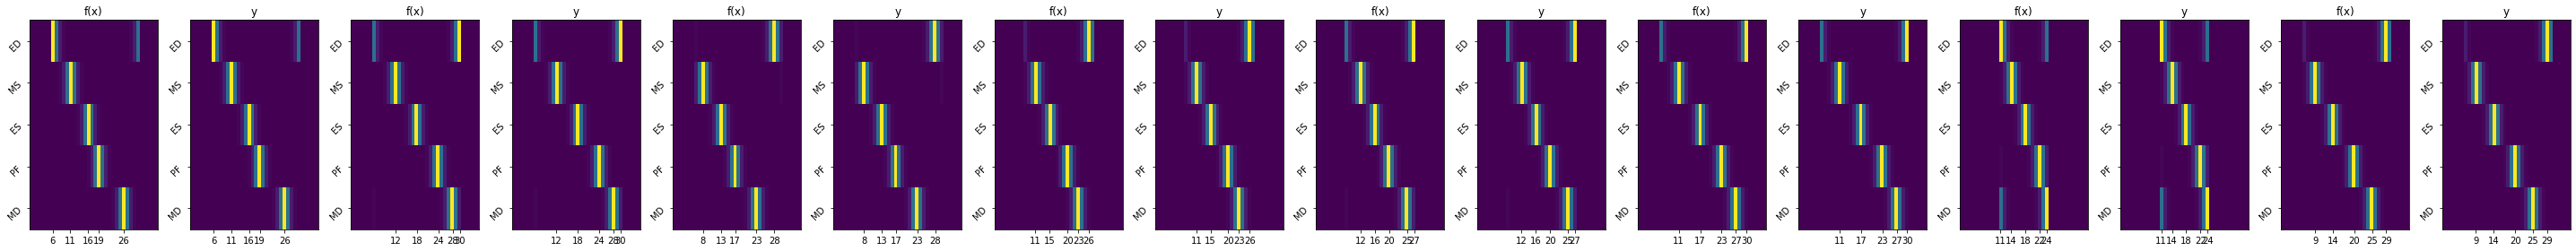

In [13]:
from src.visualization.Visualize import show_phases, show_phases_transpose
_ = show_phases_transpose(outputs,outputs)

In [11]:
# calculate the meandiff score for one batch
from src.utils.Metrics import meandiff, meandiff_transpose
score_fn = meandiff_transpose
score_fn(outputs, outputs).numpy()

gt_idx shape: (8, 5)
pred_idx shape: (8, 5)
filled shape: (8, 5)


0.0

(8, 36, 5)
(5, 36, 8)


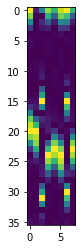

In [13]:
temp = outputs[:,0,...]
print(temp.shape)
print(temp.T.shape)
plt.imshow(temp.T[0])

In [17]:
# calculate the meandiff score for all batches
# calculate the meandiff score for one batch
from src.utils.Metrics import meandiff
score_fn = meandiff
scores = []
for batch in validation_generator:
    x,y = batch
    p = model(x)
    scores.append(score_fn(y,p))
scores

[<tf.Tensor: shape=(), dtype=float32, numpy=6.25>,
 <tf.Tensor: shape=(), dtype=float32, numpy=7.5>,
 <tf.Tensor: shape=(), dtype=float32, numpy=8.25>,
 <tf.Tensor: shape=(), dtype=float32, numpy=7.875>,
 <tf.Tensor: shape=(), dtype=float32, numpy=6.875>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.5>,
 <tf.Tensor: shape=(), dtype=float32, numpy=7.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=4.75>]

In [18]:
tf.reduce_mean(scores).numpy()

6.75

# Generator tests

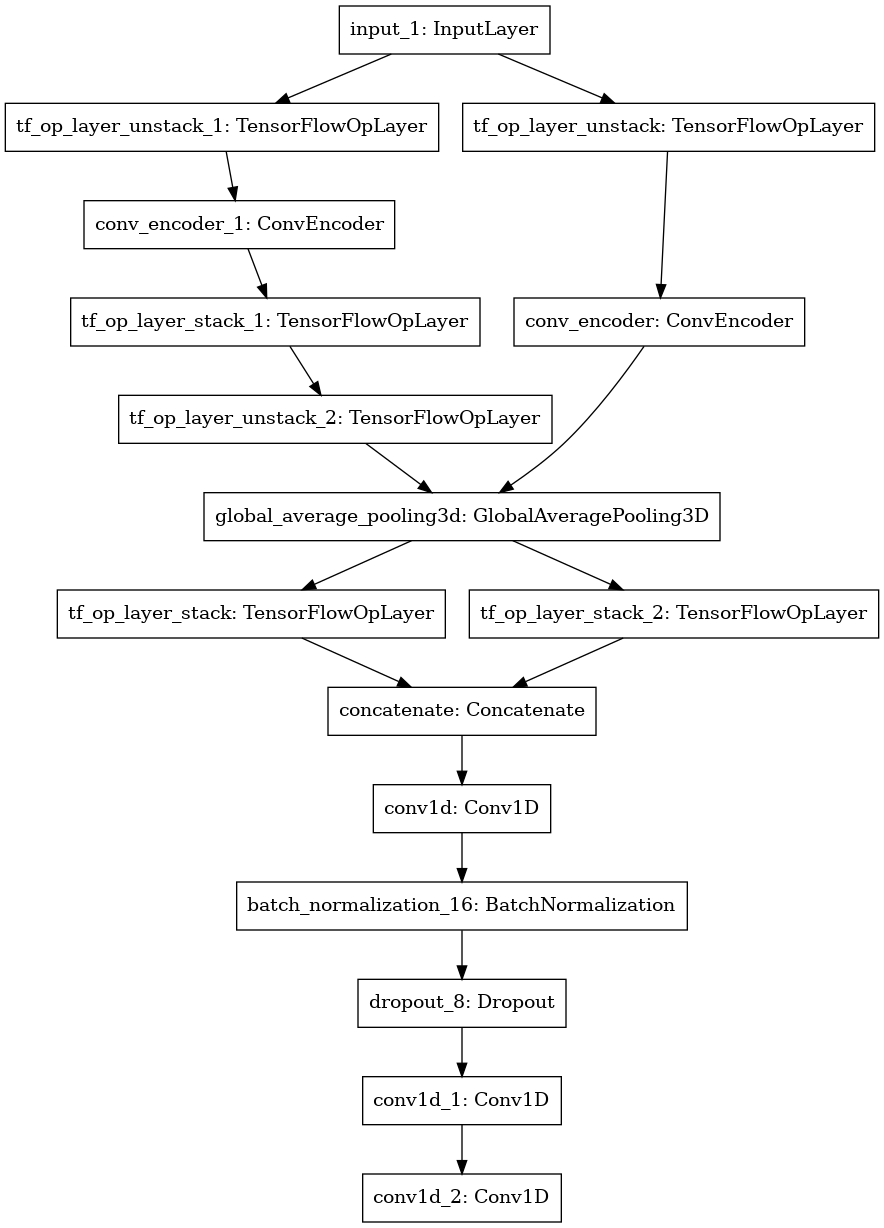

In [16]:
tf.keras.utils.plot_model(
    model, show_shapes=False,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96
)

In [19]:
score_fn = meandiff_
score_fn(outputs, pred).numpy()

1.75

In [ ]:
onehot = np.array([[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]])

In [ ]:
onehot.shape

In [ ]:
onehot_t = onehot.T
onehot_t.shape
onehot_t

In [ ]:
print(np.argmax(onehot, axis=1))
print(np.argmax(onehot_t, axis=0))

In [ ]:
# iterate over the phases j
# linspace from i to i+1 from indices
temp = onehot_t[:,0].astype(float)
i = 0
j = 3 + 1
temp[i:j] = np.linspace(i,j,j-i)
temp

In [ ]:
onehot_t = onehot_t.astype(float)
indices = np.argmax(onehot_t, axis=0)
for i in range(onehot_t.shape[1]) :
    start = indices[i]
    # make it a ring
    second = (i+1)%len(indices)
    end = indices[second]
    onehot_t[start:end,i] = np.linspace(1,0,int(end-start))
onehot_t
             
    

In [ ]:
plt.imshow(temp)

In [ ]:
plt.imshow(temp.T)

In [ ]:
%%timeit
temp.mean()

In [ ]:
%%timeit
np.mean(temp)

In [ ]:
np.linspace(-1,1,10)